In [15]:
!pip install tensorflow-gpu==2.9.3

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 0.0/444.1 MB ? eta -:--:--
     ---------------------------------------- 0.1/444.1 MB 1.7 MB/s eta 0:04:29
     ---------------------------------------- 0.1/444.1 MB 1.7 MB/s eta 0:04:21
     ---------------------------------------- 0.2/444.1 MB 1.6 MB/s eta 0:04:38
     ---------------------------------------- 0.3/444.1 MB 1.8 MB/s eta 0:04:09
     ---------------------------------------- 0.4/444.1 MB 1.8 MB/s eta 0:04:10
     ---------------------------------------- 0.5/444.1 MB 1.8 MB/s eta 0:04:11
     ---------------------------------------- 0.6/444.1 MB 1.8 MB/s eta 0:04:12
     ---------------------------------------- 0.6/444.1 MB 1.8 MB/s eta 0:04:11
     ---------------------------------------- 0.7/444.1 MB 1.8 MB/s eta 0:04:12
     ---------------------------------------- 0.8/444.1 MB 1.8 MB/s eta 0:04:12
     ---------------------------------------- 0.9/444.

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\tensorflow\\~-te\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
load_path='E:/VA/onehandtwohand/128/106words_DSLR_FH/'
CATEGORIES=np.load(load_path+'cat_106.npy', allow_pickle=True)
IMG_SIZE=128
cat_len=len(CATEGORIES)
print(cat_len)
X=np.load(load_path+'X_dslr.npy', allow_pickle=True)
Y=np.load(load_path+'Y_dslr.npy', allow_pickle=True)
# X = X.astype('float32')
# X /= 255

106


In [3]:
Y_new=[]
for i in range(len(X)):
    index = (Y[i].tolist()).index(1)
    Y_new.append(index)
len(Y_new)

Y=np.array(Y_new)
print(Y.shape)

(43469,)


In [4]:
print('Splitting') 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = cat_len)
X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size = 0.2, random_state = cat_len)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_new = np.array(X_new)
y_new = np.array(y_new)

print("pass")
del X,Y

Splitting
pass


In [5]:
num_classes = cat_len
input_shape = (IMG_SIZE, IMG_SIZE, 3)
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 100
num_epochs = 400
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [6]:
# print('Image Data Augmentation')
# from keras.preprocessing.image import ImageDataGenerator
# val_generator = ImageDataGenerator(rotation_range=0, zoom_range=0.2, width_shift_range=0.2,
#     height_shift_range=0.2, shear_range=0.2, resize=(image_size, image_size,3))
# #                                     , horizontal_flip=True, brightness_range=[0.6,1.3])
# val_generator.fit(X_train)
# val_generator.fit(X_new)
# val_generator.fit(X_test)

# print("done")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


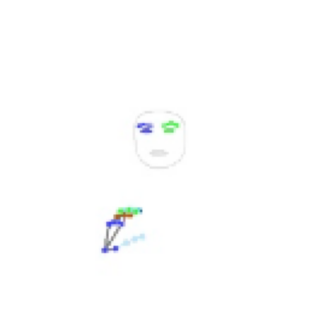

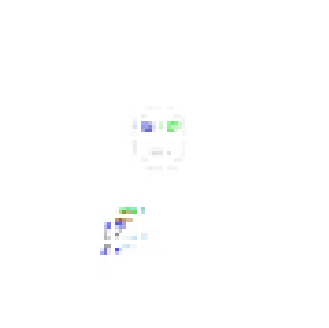

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow((image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [12]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [13]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = load_path+"tmp"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model, history


vit_classifier = create_vit_classifier()
model, history = run_experiment(vit_classifier)

Epoch 1/400
220/220 [==============================] - 17s 59ms/step - loss: 4.7969 - accuracy: 0.0172 - top-5-accuracy: 0.0774 - val_loss: 4.3778 - val_accuracy: 0.0805 - val_top-5-accuracy: 0.2333
Epoch 2/400
220/220 [==============================] - 13s 57ms/step - loss: 4.1594 - accuracy: 0.0587 - top-5-accuracy: 0.2092 - val_loss: 3.5238 - val_accuracy: 0.2287 - val_top-5-accuracy: 0.4986
Epoch 3/400
220/220 [==============================] - 12s 57ms/step - loss: 3.5300 - accuracy: 0.1293 - top-5-accuracy: 0.3743 - val_loss: 2.7657 - val_accuracy: 0.3491 - val_top-5-accuracy: 0.6608
Epoch 4/400
220/220 [==============================] - 13s 60ms/step - loss: 3.0875 - accuracy: 0.1979 - top-5-accuracy: 0.4922 - val_loss: 2.4758 - val_accuracy: 0.3725 - val_top-5-accuracy: 0.7010
Epoch 5/400
220/220 [==============================] - 12s 57ms/step - loss: 2.7883 - accuracy: 0.2481 - top-5-accuracy: 0.5770 - val_loss: 2.0980 - val_accuracy: 0.4780 - val_top-5-accuracy: 0.7910
Epoch

220/220 [==============================] - 9s 39ms/step - loss: 0.2489 - accuracy: 0.9199 - top-5-accuracy: 0.9969 - val_loss: 0.3145 - val_accuracy: 0.8990 - val_top-5-accuracy: 0.9947
Epoch 43/400
220/220 [==============================] - 9s 40ms/step - loss: 0.2525 - accuracy: 0.9215 - top-5-accuracy: 0.9960 - val_loss: 0.3263 - val_accuracy: 0.8998 - val_top-5-accuracy: 0.9938
Epoch 44/400
220/220 [==============================] - 9s 39ms/step - loss: 0.2559 - accuracy: 0.9195 - top-5-accuracy: 0.9963 - val_loss: 0.2753 - val_accuracy: 0.9121 - val_top-5-accuracy: 0.9967
Epoch 45/400
220/220 [==============================] - 13s 58ms/step - loss: 0.2326 - accuracy: 0.9274 - top-5-accuracy: 0.9974 - val_loss: 0.2231 - val_accuracy: 0.9347 - val_top-5-accuracy: 0.9984
Epoch 46/400
220/220 [==============================] - 9s 40ms/step - loss: 0.2197 - accuracy: 0.9318 - top-5-accuracy: 0.9978 - val_loss: 0.2137 - val_accuracy: 0.9290 - val_top-5-accuracy: 0.9979
Epoch 47/400
220/

220/220 [==============================] - 9s 40ms/step - loss: 0.1278 - accuracy: 0.9618 - top-5-accuracy: 0.9991 - val_loss: 0.2776 - val_accuracy: 0.9088 - val_top-5-accuracy: 0.9975
Epoch 84/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1435 - accuracy: 0.9561 - top-5-accuracy: 0.9992 - val_loss: 0.2277 - val_accuracy: 0.9265 - val_top-5-accuracy: 0.9988
Epoch 85/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1319 - accuracy: 0.9601 - top-5-accuracy: 0.9993 - val_loss: 0.1968 - val_accuracy: 0.9269 - val_top-5-accuracy: 0.9984
Epoch 86/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1348 - accuracy: 0.9591 - top-5-accuracy: 0.9989 - val_loss: 0.2306 - val_accuracy: 0.9273 - val_top-5-accuracy: 0.9967
Epoch 87/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1506 - accuracy: 0.9537 - top-5-accuracy: 0.9990 - val_loss: 0.1741 - val_accuracy: 0.9437 - val_top-5-accuracy: 0.9979
Epoch 88/400
220/2

220/220 [==============================] - 9s 40ms/step - loss: 0.1181 - accuracy: 0.9656 - top-5-accuracy: 0.9994 - val_loss: 0.2455 - val_accuracy: 0.9240 - val_top-5-accuracy: 0.9984
Epoch 125/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1269 - accuracy: 0.9625 - top-5-accuracy: 0.9988 - val_loss: 0.1465 - val_accuracy: 0.9548 - val_top-5-accuracy: 0.9996
Epoch 126/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1207 - accuracy: 0.9630 - top-5-accuracy: 0.9992 - val_loss: 0.1675 - val_accuracy: 0.9429 - val_top-5-accuracy: 0.9996
Epoch 127/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1184 - accuracy: 0.9634 - top-5-accuracy: 0.9992 - val_loss: 0.1973 - val_accuracy: 0.9343 - val_top-5-accuracy: 0.9996
Epoch 128/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1277 - accuracy: 0.9609 - top-5-accuracy: 0.9992 - val_loss: 0.0860 - val_accuracy: 0.9749 - val_top-5-accuracy: 0.9996
Epoch 129/400


220/220 [==============================] - 9s 40ms/step - loss: 0.1122 - accuracy: 0.9663 - top-5-accuracy: 0.9997 - val_loss: 0.1394 - val_accuracy: 0.9569 - val_top-5-accuracy: 0.9992
Epoch 166/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1287 - accuracy: 0.9611 - top-5-accuracy: 0.9992 - val_loss: 0.0866 - val_accuracy: 0.9754 - val_top-5-accuracy: 0.9992
Epoch 167/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1142 - accuracy: 0.9643 - top-5-accuracy: 0.9995 - val_loss: 0.1292 - val_accuracy: 0.9565 - val_top-5-accuracy: 0.9979
Epoch 168/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1267 - accuracy: 0.9614 - top-5-accuracy: 0.9991 - val_loss: 0.1075 - val_accuracy: 0.9655 - val_top-5-accuracy: 0.9996
Epoch 169/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1162 - accuracy: 0.9669 - top-5-accuracy: 0.9994 - val_loss: 0.1137 - val_accuracy: 0.9647 - val_top-5-accuracy: 0.9992
Epoch 170/400


220/220 [==============================] - 9s 40ms/step - loss: 0.1121 - accuracy: 0.9667 - top-5-accuracy: 0.9997 - val_loss: 0.1046 - val_accuracy: 0.9671 - val_top-5-accuracy: 1.0000
Epoch 207/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1226 - accuracy: 0.9628 - top-5-accuracy: 0.9993 - val_loss: 0.3182 - val_accuracy: 0.8994 - val_top-5-accuracy: 0.9922
Epoch 208/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1277 - accuracy: 0.9622 - top-5-accuracy: 0.9993 - val_loss: 0.1030 - val_accuracy: 0.9684 - val_top-5-accuracy: 0.9984
Epoch 209/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1155 - accuracy: 0.9644 - top-5-accuracy: 0.9991 - val_loss: 0.1091 - val_accuracy: 0.9692 - val_top-5-accuracy: 0.9984
Epoch 210/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1118 - accuracy: 0.9673 - top-5-accuracy: 0.9993 - val_loss: 0.1267 - val_accuracy: 0.9651 - val_top-5-accuracy: 0.9971
Epoch 211/400


220/220 [==============================] - 9s 40ms/step - loss: 0.1058 - accuracy: 0.9681 - top-5-accuracy: 0.9992 - val_loss: 0.0857 - val_accuracy: 0.9721 - val_top-5-accuracy: 1.0000
Epoch 248/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1136 - accuracy: 0.9658 - top-5-accuracy: 0.9994 - val_loss: 0.1253 - val_accuracy: 0.9610 - val_top-5-accuracy: 0.9988
Epoch 249/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1148 - accuracy: 0.9652 - top-5-accuracy: 0.9992 - val_loss: 0.0847 - val_accuracy: 0.9713 - val_top-5-accuracy: 0.9996
Epoch 250/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1040 - accuracy: 0.9689 - top-5-accuracy: 0.9999 - val_loss: 0.0997 - val_accuracy: 0.9692 - val_top-5-accuracy: 1.0000
Epoch 251/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1113 - accuracy: 0.9670 - top-5-accuracy: 0.9994 - val_loss: 0.0922 - val_accuracy: 0.9671 - val_top-5-accuracy: 0.9996
Epoch 252/400


220/220 [==============================] - 9s 39ms/step - loss: 0.1016 - accuracy: 0.9697 - top-5-accuracy: 0.9996 - val_loss: 0.0946 - val_accuracy: 0.9696 - val_top-5-accuracy: 0.9992
Epoch 289/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1055 - accuracy: 0.9686 - top-5-accuracy: 0.9992 - val_loss: 0.1320 - val_accuracy: 0.9598 - val_top-5-accuracy: 0.9988
Epoch 290/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1101 - accuracy: 0.9671 - top-5-accuracy: 0.9996 - val_loss: 0.1392 - val_accuracy: 0.9561 - val_top-5-accuracy: 0.9996
Epoch 291/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1146 - accuracy: 0.9654 - top-5-accuracy: 0.9992 - val_loss: 0.1743 - val_accuracy: 0.9409 - val_top-5-accuracy: 0.9988
Epoch 292/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1103 - accuracy: 0.9660 - top-5-accuracy: 0.9997 - val_loss: 0.1139 - val_accuracy: 0.9671 - val_top-5-accuracy: 1.0000
Epoch 293/400


220/220 [==============================] - 9s 39ms/step - loss: 0.1006 - accuracy: 0.9706 - top-5-accuracy: 0.9995 - val_loss: 0.0971 - val_accuracy: 0.9692 - val_top-5-accuracy: 0.9984
Epoch 330/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1078 - accuracy: 0.9680 - top-5-accuracy: 0.9994 - val_loss: 0.1355 - val_accuracy: 0.9540 - val_top-5-accuracy: 0.9979
Epoch 331/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1031 - accuracy: 0.9694 - top-5-accuracy: 0.9995 - val_loss: 0.1022 - val_accuracy: 0.9643 - val_top-5-accuracy: 1.0000
Epoch 332/400
220/220 [==============================] - 9s 40ms/step - loss: 0.1069 - accuracy: 0.9675 - top-5-accuracy: 0.9994 - val_loss: 0.0942 - val_accuracy: 0.9708 - val_top-5-accuracy: 0.9996
Epoch 333/400
220/220 [==============================] - 9s 39ms/step - loss: 0.1002 - accuracy: 0.9721 - top-5-accuracy: 0.9995 - val_loss: 0.0970 - val_accuracy: 0.9721 - val_top-5-accuracy: 0.9996
Epoch 334/400


220/220 [==============================] - 9s 41ms/step - loss: 0.0998 - accuracy: 0.9702 - top-5-accuracy: 0.9996 - val_loss: 0.1248 - val_accuracy: 0.9626 - val_top-5-accuracy: 0.9979
Epoch 371/400
220/220 [==============================] - 9s 40ms/step - loss: 0.0981 - accuracy: 0.9714 - top-5-accuracy: 0.9998 - val_loss: 0.0902 - val_accuracy: 0.9717 - val_top-5-accuracy: 0.9996
Epoch 372/400
220/220 [==============================] - 9s 41ms/step - loss: 0.1088 - accuracy: 0.9680 - top-5-accuracy: 0.9994 - val_loss: 0.1224 - val_accuracy: 0.9606 - val_top-5-accuracy: 0.9984
Epoch 373/400
220/220 [==============================] - 9s 41ms/step - loss: 0.1022 - accuracy: 0.9694 - top-5-accuracy: 0.9995 - val_loss: 0.1677 - val_accuracy: 0.9491 - val_top-5-accuracy: 0.9988
Epoch 374/400
220/220 [==============================] - 9s 41ms/step - loss: 0.1183 - accuracy: 0.9650 - top-5-accuracy: 0.9994 - val_loss: 0.1753 - val_accuracy: 0.9384 - val_top-5-accuracy: 0.9975
Epoch 375/400


In [16]:
print('Saving')
model_name1 = 'VAViT'
np.save(load_path+model_name1+'_history.npy',history.history)
model.save(load_path+model_name1+'_model.sav') 
print("saved")

Saving


INFO:tensorflow:Assets written to: E:/VA/onehandtwohand/128/106words_DSLR_FH/VAViT_model.sav\assets


INFO:tensorflow:Assets written to: E:/VA/onehandtwohand/128/106words_DSLR_FH/VAViT_model.sav\assets


saved


In [ ]:
# #load saved history
model_name1 = 'VAViT'
history_const=np.load(load_path+model_name1+'_history.npy',allow_pickle='TRUE').item()

# #load saved model
model1=load_model(load_path+model_name1+'_model.sav')

print("loaded")

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model1.predict(X_new)

Y_pred=[]
for i in range(len(X_new)):
#     index = (y_pred[i].tolist()).index(argmax())
    index = y_pred[i].argmax()
    Y_pred.append(index)
Y_pred=np.array(Y_pred)

accuracy_score(y_new, Y_pred)